# **Why Reinforcement Learning is the ML paradigm of choice for this task.**

This project attempts to use machine learning to create an agent that can play the atari game space invaders. Supervised learning methods are insufficient for this task because they would involve labelling every possible situation that could arise in the game and manually determinig the optimal action to take so that we could use a supervised learning algorithm to discover a pattern in these situation/action pairs with a view to learning what action to take given a situation. This would be impractical as it would be highly expensive to manually label all of the possible situations and even labelling say, stacks of frames as situations where x is the best action may take many years.

Unsupervised learning methods would also be insufficient. Unsupervised learning would require all of the possible situations to be captured in a data-set with each of the 6 possible actions taken in each, with the reward differences and would attempt to develop a strategy for determining the best action to take given a situation. This would, again, be highly expensive and impractical. It would also not take into account the fact that certain actions may result in proceeding situations as well as reward difference and so, therfore, would yield a poor solution.

Reinforcement learning best fits this problem because it takes into account sequences of actions and has the capacity to plan for maximum reward in the long term rather than basing all decisions on immediate reward. This will yield a superior solution to the space invaders problem. It also doesn't require any human labelled data or any large datasets, it will learn by live trial and error.

# **Install Depenencies**

In [ ]:
!pip install gym[atari] ale-py autorom
!AutoROM --accept-license

AutoROM will download the Atari 2600 ROMs.
They will be installed to:
	/usr/local/lib/python3.11/dist-packages/AutoROM/roms

Existing ROMs will be overwritten.


In [ ]:
!pip install numpy==1.24.3

# **Imports**

In [ ]:
!nvidia-smi

Tue May 13 18:58:09 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   41C    P8             11W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import os
import cv2
import gym
import copy # to clone the model
import torch
import random
import pickle
import numpy as np
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
from collections import deque, namedtuple

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# **The Environment**

In [ ]:
# a) game - Space Invaders
# b) inputs recieved from gym environment
# c) control settings for joystick

environment = gym.make('SpaceInvaders-v4')

print("Game Chosen : Space Invaders \n")
print("---------------------- \n")
print("Possible Actions in Space Invaders : ")
print(environment.action_space)
print(environment.unwrapped.get_action_meanings(), "\n")
print("---------------------- \n")
print("Raw pixel data recieved from environment (observation) : ")
# print(f"Shape : {np.shape(environment.reset())}")
print(environment.reset()[1:], "\n")
print("---------------------- \n")
print("List of data recieved from environment (reward, terminated, truncated, info) : ")
print(environment.step(1)[1:], "\n")
print("")
print("---------------------- \n")

Game Chosen : Space Invaders 

---------------------- 

Possible Actions in Space Invaders : 
Discrete(6)
['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE'] 

---------------------- 

Raw pixel data recieved from environment (observation) : 
({'lives': 3, 'episode_frame_number': 0, 'frame_number': 0},) 

---------------------- 

List of data recieved from environment (reward, terminated, truncated, info) : 
(0.0, False, False, {'lives': 3, 'episode_frame_number': 2, 'frame_number': 2}) 


---------------------- 



/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


# **DQN Implementation**

In [ ]:
class DQN(nn.Module):
  def __init__(self, num_frames, num_actions):
    super(DQN, self).__init__()
    self.num_frames = num_frames
    self.num_actions = num_actions

    self.conv1 = nn.Conv2d(
        in_channels=self.num_frames,
        out_channels=16,
        kernel_size=8,
        stride=4,
        padding=2
    )

    self.conv2 = nn.Conv2d(
        in_channels=16,
        out_channels=32,
        kernel_size=4,
        stride=2,
        padding=1
    )

    self.fc1 = nn.Linear(
        in_features = 3200,
        out_features = 256
    )

    self.fc2 = nn.Linear(
        in_features = 256,
        out_features = self.num_actions
    )


    self.relu = nn.ReLU()

  def flatten(self, x):
    batch_size = x.size()[0]
    return x.view(batch_size, -1)

  def forward(self, x):
    x = self.relu(self.conv1(x)) # Input shape : (84 * 84 * 4) , Output shape : (21 * 21 * 16)
    x = self.relu(self.conv2(x)) # Input shape : (21 * 21 * 16) , Output shape : (10 * 10 * 32)

    x = self.flatten(x) # -> (3200)
    x = self.relu(self.fc1(x)) # Input shape : (3200) , Output shape : (256)
    x = self.fc2(x) # Input shape : (256) , Output shape : (6)

    return x


In [ ]:
class Agent:
  def __init__(self, model, lr, gamma, starting_epsilon, ending_epsilon, greedy_time, memory_depth, episodes, time, batch_size, experience_time, device):

    self.device = device
    self.experience_time = experience_time
    self.batch_size = batch_size
    self.time = time
    self.model = model
    self.lr = lr
    self.gamma = gamma
    self.starting_epsilon = starting_epsilon
    self.ending_epsilon = ending_epsilon
    self.greedy_time = greedy_time
    self.memory_depth = memory_depth
    self.episodes = episodes


    self.clone()
    self.memory = deque(maxlen=self.memory_depth)
    self.loss = nn.SmoothL1Loss()
    self.optimiser = torch.optim.RMSprop(self.model.parameters(), lr=lr, alpha=0.95, eps=0.01)


  def clone(self):
    self.cloned_model = copy.deepcopy(self.model).to(self.device)
    return self.cloned_model

  def preprocess(self, state):
    '''
    downsample, crop and grayscale frame
    return -> 'state' tensor
    '''
    # convert to greyscale
    state = cv2.cvtColor(state, cv2.COLOR_BGR2GRAY)
    # down-sample to 110*84
    state = cv2.resize(state, (110, 84)) #width , height -> 84 rows, 110 cols
    # crop to 84*84
    state = state[:, 18:102] #84 columns around the centre
    # add axes for batch and channels (every frame will be preprocessed and then concatenated along the channel axis of state)
    # where state is our 4 frame stack we pass to the Q network (we need a stack so the model can determine movement)
    state = state[np.newaxis, np.newaxis, :, :]

    # return the frame as a tensor of size [1,1,84,84]
    return torch.tensor(state, dtype=torch.float32, device=self.device)


  def epsilon_greedy(self, t):
    # greedy decay as per DeepMind paper
    frac = min(1.0, t / self.greedy_time)
    return self.starting_epsilon - frac * (self.starting_epsilon - self.ending_epsilon)

  @torch.no_grad()
  def best_action(self, state):
    q_values = self.model(state).squeeze(0)
    return int(torch.argmax(q_values).item())

  def update(self, batch_size):

    if len(self.memory) < batch_size:
      # theres nothing to train on yet in this case
      return 0.0

    self.model.zero_grad()
    state, action, reward, terminal, next_state = self.pull(batch_size)

    with torch.no_grad():
      qmax = self.cloned_model(next_state).max(dim=1)[0]
      target = reward + self.gamma * qmax * (1 - terminal.float())

    q = self.model(state).gather(1, action.view(batch_size, 1)).squeeze(1)
    loss = self.loss(q, target)
    loss.backward()
    self.optimiser.step()
    # stabalise gpu ram usage a bit .. hopefully?
    torch.cuda.empty_cache()
    return loss.item()


  def push(self, state, action, reward, terminal, next_state):
    state_np = (state.cpu().numpy()*255).astype(np.uint8)
    next_np = (next_state.cpu().numpy()*255).astype(np.uint8)

    self.memory.append(replay_memory(state_np, action.cpu(), reward.cpu(), terminal.cpu(), next_np))

  def pull(self, batch_size):
    transitions = random.sample(self.memory, batch_size)

    states = []
    actions = []
    rewards = []
    terminals = []
    next_states= []

    for trans in transitions:
      states.append(trans.state)
      actions.append(trans.action)
      rewards.append(trans.reward)
      terminals.append(trans.terminal)
      next_states.append(trans.next_state)

    state_tensor = torch.tensor(np.concatenate(states, 0), dtype=torch.float32, device=self.device) / 255.0
    next_state_tensor = torch.tensor(np.concatenate(next_states, 0), dtype=torch.float32, device=self.device) / 255.0

    action = torch.cat(actions).to(self.device)
    reward = torch.cat(rewards).to(self.device)
    terminal = torch.cat(terminals).to(self.device)


    return state_tensor, action, reward, terminal, next_state_tensor


  def plot(self, data, outfile='training_plot.png'):
    plt.figure()
    plt.plot(data['episode'], data['reward'])
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Reward over Episodes')
    plt.savefig(outfile)
    plt.close()

  def save(self, data, logfile='training_plot.pkl'):
    with open(logfile, 'wb') as f:
      pickle.dump(data, f)


  def play(self, episodes, train, load):

    data = {
        'episode' : [],
        'reward' : []
    }
    i = 0
    self.time = 0
    try:
      for episode in range(self.episodes):
        # start the emulator + process the 210*160 pixel image
        state, _ = environment.reset()
        # process the raw input
        state = self.preprocess(state)
        total_reward = 0
        terminated = False

        while not terminated:
          # while we don't yet have 4 frames to stack (at the start)
          while state.size()[1] < num_frames:
            # load up the next frame (we just use action=1 for now because we don't yet have 4 frames to pass to the DQN)
            # we don't need truncated or info variables so we ignore them
            next_frame, reward, terminated, _, _ = environment.step(1)
            # preprocess the new frame same as the first
            next_frame = self.preprocess(next_frame)
            # concatenate next_frame ([1,1,84,84]) with state (our stack of frames) at the channels axes (dim=1)
            # if state was of size ([1,2,84,84]) say, this would change to ([1,3,84,84])
            state = torch.cat((state, next_frame), 1)

          # /////////////////////////////////////////////////////
          # Now we're ready to start playing
          # /////////////////////////////////////////////////////

          # We are going to implement an e-greedy approach so we need to add the logic for when we will pick the
          # optimal action(exploit) and when we will pick a random action(explore)

          # if we're training and not feeling greedy
          if train and np.random.uniform() < self.epsilon_greedy(self.time):
            action = np.random.randint(num_actions)
          else:
            action = self.best_action(state)


          next_frame, reward, terminated, _, _ = environment.step(action)
          next_frame = self.preprocess(next_frame)
          next_state = torch.cat((state, next_frame), 1)
          # keep the newest 4 frames i.e from index 1 onwards
          next_state = next_state[:, 1:, :, :]


          if train:
            # convert variables to tensors before pushing them to replay memory
            reward = torch.tensor([reward], dtype=torch.float, device=self.device)
            action = torch.tensor([action], dtype=torch.long, device=self.device)
            terminated = torch.tensor([terminated], dtype=torch.uint8, device=self.device)

            self.push(state, action, reward, terminated, next_state)

          state = next_state
          total_reward += reward.item()
          self.time += 1
          i += 1

          # if we're training and we've had enough time to fill the replay memory (50k) and if we have enough for a batch
          if train and self.time > self.experience_time and len(self.memory) > self.batch_size:

            if self.time % update_time == 0:
              # print("Updating")
              self.update(batch_size)
            if self.time % clone_time == 0:
              self.clone()

        data['episode'].append(episode)
        data['reward'].append(total_reward)
        print("Episode :", episode)
        print("Reward : ", total_reward)

        if episode % 100 == 0:
          self.plot(data)

      environment.close()
      return data
    finally:
      environment.close()
      self.plot(data)
      return data


In [ ]:
replay_memory = namedtuple('ReplayMemory', ('state', 'action', 'reward', 'terminal', 'next_state'))

In [ ]:
# Hyperparameters
time = 0
update_time = 4
clone_time = 10000
save_time = 10000
greedy_time = 1000000
experience_time = 50000 #same as DeepMind paper


num_actions = environment.action_space.n
num_frames = 4
# Available ram on colab only 40GB - training loop can't run to completion (Ran on kaggle (20h))
episodes = 10000
memory_depth = 1000000
batch_size = 32


lr = 2.5e-4
gamma = 0.99
starting_epsilon = 1
ending_epsilon = 0.1

In [ ]:
model = DQN(num_actions=num_actions, num_frames=num_frames).to(device)

In [ ]:
agent = Agent(model, lr, gamma, starting_epsilon, ending_epsilon, greedy_time, memory_depth, episodes, time, batch_size, experience_time, device)

In [ ]:
data = agent.play(episodes, train=True, load=False)

Episode : 0
Reward :  65.0
Episode : 1
Reward :  105.0
Episode : 2
Reward :  105.0
Episode : 3
Reward :  150.0
Episode : 4
Reward :  35.0
Episode : 5
Reward :  180.0
Episode : 6
Reward :  30.0
Episode : 7
Reward :  135.0
Episode : 8
Reward :  380.0
Episode : 9
Reward :  75.0
Episode : 10
Reward :  105.0
Episode : 11
Reward :  105.0
Episode : 12
Reward :  45.0
Episode : 13
Reward :  135.0
Episode : 14
Reward :  230.0
Episode : 15
Reward :  130.0
Episode : 16
Reward :  50.0
Episode : 17
Reward :  120.0
Episode : 18
Reward :  30.0
Episode : 19
Reward :  135.0
Episode : 20
Reward :  305.0
Episode : 21
Reward :  20.0
Episode : 22
Reward :  120.0
Episode : 23
Reward :  60.0
Episode : 24
Reward :  130.0
Episode : 25
Reward :  150.0
Episode : 26
Reward :  85.0
Episode : 27
Reward :  105.0
Episode : 28
Reward :  120.0
Episode : 29
Reward :  240.0
Episode : 30
Reward :  110.0
Episode : 31
Reward :  185.0
Episode : 32
Reward :  165.0
Episode : 33
Reward :  90.0
Episode : 34
Reward :  120.0
Episod

**Capture and Pre-Processing of the Data**

Data capture is handled live within the Agent class, environment.step() is called to gather data from each new frame.
Data preprocessing is also handled within the Agent class in the preprocess method. Using Cv2, the new frames are cropped, resized to 84*84 squares and converted to greyscale. This reduces dimensionality while retaining necessary features. The new image is then converted to a tensor of shape [1, 1, 84, 84] so it can then be stacked in the play method to form a state which consists of 4 frames so as to capture motion.

**The Network Structure**

The network is based on the original DeepMind Paper (Minh et al., 2013) and mathces it exactly as described in the paper. We take a 4 * 84 * 84 input, perform convolution with 16, 8*8 filters with stride 4 and padding 2 outputting 16 * 21 * 21. We them convolve again with 32, 4 * 4 filters with stride 2 and padding 2 outputting 32 * 10 * 10. We then flatten that outputting (3200,) and pass it to the fully connected layer outputting (256,) followed by the next fully connected layer outputting 6, (One value per possible action which each after training will represent future estimated reward given that action)

**The Q-Learning Update Applied to the weights**

During training, the vanilla DQN adjusts its weights through a standard Q-learning loop. At each update step the agent samples a mini-batch of size 32 each containing (state, action, reward, next_state, terminal) from the replay memory. It runs a forward pass on the main network on the current state to get predicted action values Q(s) and Q(s, a). The next_state is fed through the clone network to compute max(Q_target(s', a')). The learning target is then formed by the Bellman equation y = r + y * (1 - terminal)max(Q_target(s', a')). The network then aims to minimise the smooth L1 or Huber loss between Q(s, a) and target. It then backpropagates the gradient using RMSProp with lr = 2.5e-4, a=.95 and e=0.01. One optimisation step is made every four environment frames while the target network is refreshed (copies the main network weights) every 10k frames to keep stable. Exploration v.s exploitation is controlled by e-greedy ploicy that decays linearly from 1 to 0.1 over the first million frames ensuring plenty of time for early exploration.


# **Results and Evaluation of Vanilla DQN**

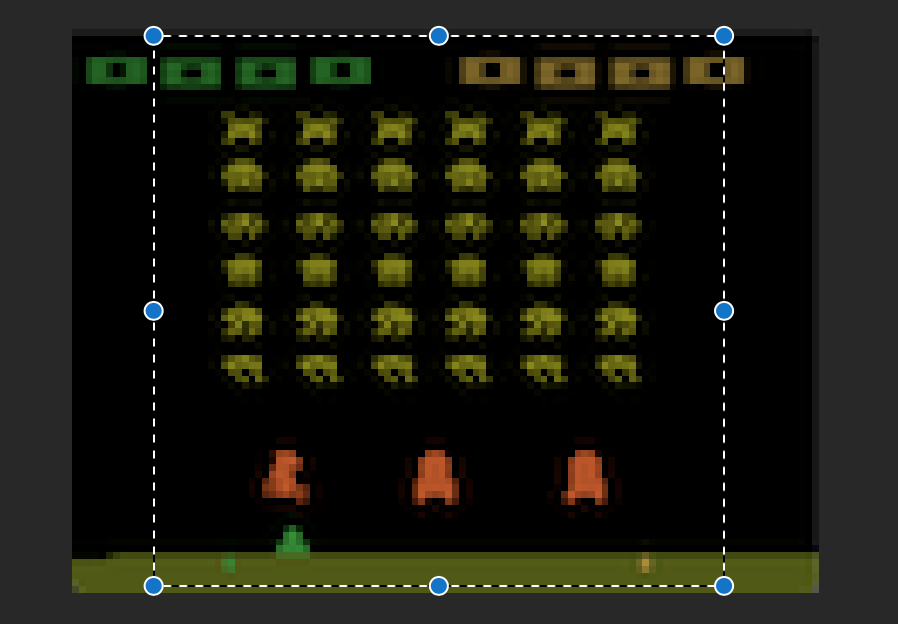

Representation of what the downsampled and cropped image looks like (without greyscale)

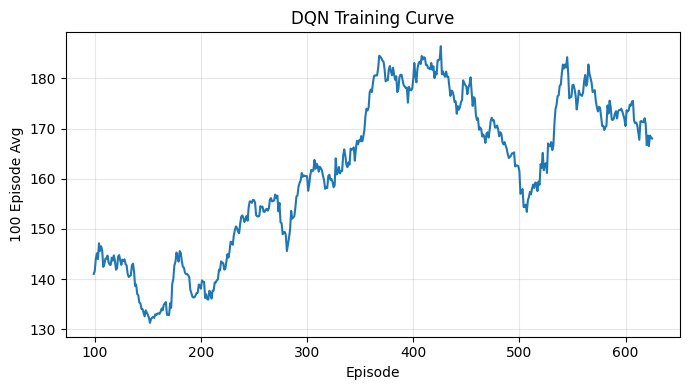

In [ ]:
episodes = np.array(data['episode'])
rewards = np.array(data['reward'])

window = 100
cumulative_sum = np.cumsum(np.insert(rewards, 0, 0))
mean = (cumulative_sum[window:] - cumulative_sum[:-window]) / window
mean_full = np.concatenate([rewards[:window-1], mean])

plt.figure(figsize=(7,4))
plt.plot(episodes[99:], mean_full[99:])
plt.xlabel('Episode')
plt.ylabel('100 Episode Avg')
plt.title('DQN Training Curve')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

**Explaination of Information Conveyed**

The vanilla DQN training curve above shows average reward per episode smoothed with a 100 episode moving average. From this graph we can see high variation even after smoothing. There is a gradual rise to 170 reward from episode 100 to 350 which may indicate the agent is learning some basic strategies like shoot more to earn more reward or move under a shield. Both strategies boost early reward but don't get you far on their own. From episode 350 to 400 there is another rise to over 180 reward but this oscilates heavily until the end of the run at episode 620. This may indicate the agent began to favour suboptimal actions damaging performance. All in all, the graph demonstrates that the vanilla DQN is learning but is prone to instability, gains are often followed by eratic drops in performance.

----

# **Double DQN Implementation**

In [ ]:
class DoubleAgent: #... get it
  def __init__(self, model, lr, gamma, starting_epsilon, ending_epsilon, greedy_time, memory_depth, episodes, time, batch_size, experience_time, device):

    self.device = device
    self.experience_time = experience_time
    self.batch_size = batch_size
    self.time = time
    self.model = model
    self.lr = lr
    self.gamma = gamma
    self.starting_epsilon = starting_epsilon
    self.ending_epsilon = ending_epsilon
    self.greedy_time = greedy_time
    self.memory_depth = memory_depth
    self.episodes = episodes


    self.clone()
    self.memory = deque(maxlen=self.memory_depth)
    self.loss = nn.SmoothL1Loss()
    self.optimiser = torch.optim.RMSprop(self.model.parameters(), lr=lr, alpha=0.95, eps=0.01)


  def clone(self):
    self.cloned_model = copy.deepcopy(self.model).to(self.device)
    return self.cloned_model

  def preprocess(self, state):
    '''
    downsample, crop and grayscale frame
    return -> 'state' tensor
    '''
    # convert to greyscale
    state = cv2.cvtColor(state, cv2.COLOR_BGR2GRAY)
    # down-sample to 110*84
    state = cv2.resize(state, (110, 84)) #width , height -> 84 rows, 110 cols
    # crop to 84*84
    state = state[:, 18:102] #84 columns around the centre
    # add axes for batch and channels (every frame will be preprocessed and then concatenated along the channel axis of state)
    # where state is our 4 frame stack we pass to the Q network (we need a stack so the model can determine movement)
    state = state[np.newaxis, np.newaxis, :, :]

    # return the frame as a tensor of size [1,1,84,84]
    return torch.tensor(state, dtype=torch.float32, device=self.device)


  def epsilon_greedy(self, t):
    # greedy decay as per DeepMind paper
    frac = min(1.0, t / self.greedy_time)
    return self.starting_epsilon - frac * (self.starting_epsilon - self.ending_epsilon)

  @torch.no_grad()
  def best_action(self, state):
    q_values = self.model(state).squeeze(0)
    return int(torch.argmax(q_values).item())

  def update(self, batch_size):

    if len(self.memory) < batch_size:
      # theres nothing to train on yet in this case
      return 0.0

    self.model.zero_grad()
    state, action, reward, terminal, next_state = self.pull(batch_size)





    # //////////////////////////////////////
    # Double DQN Implementation
    # /////////////////////////////////////
    q_all = self.model(state)
    q = q_all.gather(1, action.view(batch_size, 1)).squeeze(1)

    with torch.no_grad():
      next_q = self.model(next_state)
      next_actions = torch.argmax(next_q, dim=1)

      next_q_target = self.cloned_model(next_state)
      qmax = next_q_target.gather(1, next_actions.unsqueeze(1)).squeeze(1)

      target = reward + gamma * qmax * (1 - terminal.float())
    # /////////////////////////////////////






    loss = self.loss(q, target)
    loss.backward()
    self.optimiser.step()
    # stabalise gpu usage a bit .. hopefully?
    torch.cuda.empty_cache()
    return loss.item()


  def push(self, state, action, reward, terminal, next_state):
    state_np = (state.cpu().numpy()*255).astype(np.uint8)
    next_np = (next_state.cpu().numpy()*255).astype(np.uint8)

    self.memory.append(replay_memory(state_np, action.cpu(), reward.cpu(), terminal.cpu(), next_np))

  def pull(self, batch_size):
    transitions = random.sample(self.memory, batch_size)

    states = []
    actions = []
    rewards = []
    terminals = []
    next_states= []

    for trans in transitions:
      states.append(trans.state)
      actions.append(trans.action)
      rewards.append(trans.reward)
      terminals.append(trans.terminal)
      next_states.append(trans.next_state)

    state_tensor = torch.tensor(np.concatenate(states, 0), dtype=torch.float32, device=self.device) / 255.0
    next_state_tensor = torch.tensor(np.concatenate(next_states, 0), dtype=torch.float32, device=self.device) / 255.0

    action = torch.cat(actions).to(self.device)
    reward = torch.cat(rewards).to(self.device)
    terminal = torch.cat(terminals).to(self.device)


    return state_tensor, action, reward, terminal, next_state_tensor


  def plot(self, data, outfile='training_plot.png'):
    plt.figure()
    plt.plot(data['episode'], data['reward'])
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Reward over Episodes')
    plt.savefig(outfile)
    plt.close()

  def save(self, data, logfile='training_plot.pkl'):
    with open(logfile, 'wb') as f:
      pickle.dump(data, f)


  def play(self, episodes, train, load):

    data = {
        'episode' : [],
        'reward' : []
    }
    i = 0
    self.time = 0
    try:
      for episode in range(self.episodes):
        # start the emulator + process the 210*160 pixel image
        state, _ = environment.reset() # state, action, reward, terminal, next_state
        # process the raw input
        state = self.preprocess(state)
        total_reward = 0
        terminated = False

        while not terminated:
          # while we don't yet have 4 frames to stack (at the start)
          while state.size()[1] < num_frames:
            # load up the next frame (we just use action=1 for now because we don't yet have 4 frames to pass to the DQN)
            # we don't need truncated or info variables so we ignore them
            next_frame, reward, terminated, _, _ = environment.step(1)
            # preprocess the new frame same as the first
            next_frame = self.preprocess(next_frame)
            # concatenate next_frame ([1,1,84,84]) with state (our stack of frames) at the channels axes (dim=1)
            # if state was of size ([1,2,84,84]) say, this would change to ([1,3,84,84])
            state = torch.cat((state, next_frame), 1)

          # /////////////////////////////////////////////////////
          # Now we're ready to start playing
          # /////////////////////////////////////////////////////

          # We are going to implement an e-greedy approach so we need to add the logic for when we will pick the
          # optimal action(exploit) and when we will pick a random action(explore)

          # if we're training and we're not feeling greedy
          if train and np.random.uniform() < self.epsilon_greedy(self.time):
            action = np.random.randint(num_actions)
          else:
            action = self.best_action(state)


          next_frame, reward, terminated, _, _ = environment.step(action)
          next_frame = self.preprocess(next_frame)
          next_state = torch.cat((state, next_frame), 1)
          # keep the newest 4 frames i.e from index 1 onwards
          next_state = next_state[:, 1:, :, :]

          if train:
            # convert variables to tensors before pushing them to replay memory
            reward = torch.tensor([reward], dtype=torch.float, device=self.device)
            action = torch.tensor([action], dtype=torch.long, device=self.device)
            terminated = torch.tensor([terminated], dtype=torch.uint8, device=self.device)

            self.push(state, action, reward, terminated, next_state)

          state = next_state
          total_reward += reward.item()
          self.time += 1
          i += 1

          # if we're training and we've had enough time to fill the replay memory and if we have enough for a batch
          if train and self.time > self.experience_time and len(self.memory) > self.batch_size:
            if self.time % update_time == 0:
              self.update(batch_size)
            if self.time % clone_time == 0:
              self.clone()

        data['episode'].append(episode)
        data['reward'].append(total_reward)
        print("Episode :", episode)
        print("Reward : ", total_reward)

        if episode % 100 == 0:
          self.plot(data)

      environment.close()
      return data
    finally:
      environment.close()
      self.plot(data)
      return data


In [ ]:
# Hyperparameters
time = 0
update_time = 4
clone_time = 10000
save_time = 10000
greedy_time = 1000000
experience_time = 50000 #same as DeepMind paper

num_actions = environment.action_space.n
num_frames = 4
episodes = 10000
memory_depth = 1000000
batch_size = 32

lr = 2.5e-4
gamma = 0.99
starting_epsilon = 1
ending_epsilon = 0.1

In [ ]:
model = DQN(num_actions=num_actions, num_frames=num_frames).to(device)

In [ ]:
agent = DoubleAgent(model, lr, gamma, starting_epsilon, ending_epsilon, greedy_time, memory_depth, episodes, time, batch_size, experience_time, device)

In [ ]:
data = agent.play(episodes, train=True, load=False)

Streaming output truncated to the last 5000 lines.
Training Now
Replay Memory sufficiently full
Training Now
Replay Memory sufficiently full
Training Now
Replay Memory sufficiently full
Training Now
Done Training
Replay Memory sufficiently full
Training Now
Replay Memory sufficiently full
Training Now
Replay Memory sufficiently full
Training Now
Replay Memory sufficiently full
Training Now
Done Training
Replay Memory sufficiently full
Training Now
Replay Memory sufficiently full
Training Now
Replay Memory sufficiently full
Training Now
Replay Memory sufficiently full
Training Now
Done Training
Replay Memory sufficiently full
Training Now
Replay Memory sufficiently full
Training Now
Replay Memory sufficiently full
Training Now
Replay Memory sufficiently full
Training Now
Done Training
Replay Memory sufficiently full
Training Now
Replay Memory sufficiently full
Training Now
Replay Memory sufficiently full
Training Now
Replay Memory sufficiently full
Training Now
Done Training
Replay Memo

**Describe the Problem Being Addressed**

The problem being addressed by the DDQN is that the target value [r + gamma * max(Q(s',a')] is calculated in a way that relies on the target network both for the choice of action and the evaluation of that choice. The, 'max' operator will choose the action with the highest predicted q value even if the q value is accidentally high. This can result in overestimation which will inflate q values and destabalise learning.

**Describe the Theoretical Solution**

The theoretical solution to this problem is DDQN. In DDQN we use the main network to select the best action which reflects the weights to be trained. Then we use the target network to supply a stable evaluation of future expected reward given that action. Because the two estimates are no longer drawn from the same, possibly noisy, sample, the error in one network is unlikely to align with the other.


#**Results and Evaluation of Double DQN**

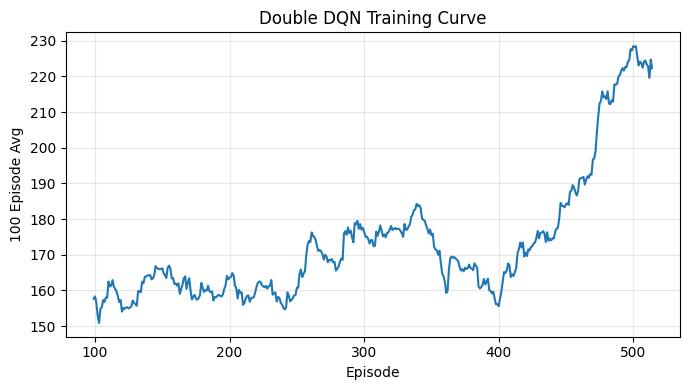

In [ ]:
episodes = np.array(data['episode'])
rewards = np.array(data['reward'])

window = 100
cumulative_sum = np.cumsum(np.insert(rewards, 0, 0))
mean = (cumulative_sum[window:] - cumulative_sum[:-window]) / window
mean_full = np.concatenate([rewards[:window-1], mean])

plt.figure(figsize=(7,4))
plt.plot(episodes[99:], mean_full[99:])
plt.xlabel('Episode')
plt.ylabel('100 Episode Avg')
plt.title('Double DQN Training Curve')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

**Explaination of Information Conveyed**

The plot above again shows the 100-episode moving average of total rewards against the training episodes. The graph conveys baseline performance around episode 100 of near 150 roughly matching the average random score outlined in the graph below under Added Value. From episodes 100 to around 350 the curve rises slowly and stays smooth showing steady improvement without heavy variation. Between episodes 350 and 480 the line climbs dramatically from 170 reward to 230 indicating the agent has discovered an improved policy demonstrating learning and is exploiting consistently. After around episode 490, the curve flattens around 220-230 average reward. Overall the graph conveys that the Double DQN delivers stable learning and reaches higher final performance than the vanilla DQN demonstrating learning and validating the theoretical advantages of Double DQN outlined earlier.

# **Comparisson of DQN Versus Double DQN**

**Theoretical Comparisson**

The difference between a vanilla DQN and a Double DQN lies in the update function. In a vanilla DQN you update the network by calculating the mean square error between the target(Bellman approximation) and the q value output of the network. The target is approximated by [reward + discount * max(clone_network(s', a'))] (Minh et al., 2013). This not only stabalises the network by providing a fixed reference point during training but also promotes learning as the reward is baked into the target calculation. By nature the network and the clone network will be relatively similar in terms of weights so the reward portion of the calculation will make the most difference in a lot of cases. We then update the network with stochastic gradient descent. It is worth noting that while we are technically using two networks here, that is not what defines a Double DQN. In a vanilla DQN we use the same network to select and evaluate the next action. When we calculate target as above we are essentially asking the clone network to choose an action and to predict how good that action is in terms of future estimated reward. This can introduce overestimation becasue if, say the true q-value (which we can't know) was 15 and the clone network predicted 30 due to some noise in the network. If we just ask the clone network its going to tell us to take the action that leads to a future reward of 30 and we're assuming its evaluation is correct.


A Double DQN splits the target calculation over the two networks yielding a Double DQN. [Target = r + y * clone_network(max(main_network(s',a'))] so this way we're getting the main network to predict the best action and the clone network to evaluate the future estimated reward of that action instead of calculating both with the clone network (Van Hasselt et al., 2015). This way noise in either network is less likely to affect loss accuracy.


**Experimental Comparisson**


The training curve graph shows the DDQN starts around episode 100 with a reward of around 150 and holds relatively stable until episode 200 where it takes off on a steep ascent to an average reward of around 230 by episode 400. The graph plateus there and remains stable until the end of the run at about episode 520.

The vanilla DQN graph starts around the same baseline at episode 100 with an average reward of about 150. The graph begins an ascent at episode 200 and peaks at an average reward of around 180 by episode 400. This graph is noticablt more volitile and takes a dive at episode 420 down to an average reward of just over 150 before rising back up to the 180 mark and dipping again.

The vanilla DQN seems to improve but then oscillate. This is likely due to overestimation as described above where q-values for certain actions get too high and the agent overcommits to suboptimal actions skewing the networks weights in the wrong directions.

The Double DQN shows a stable plateu between episodes 100 and 400 as it is less prone to overestimation so improvements seem to be slower but more consistent. After episode 400 the policy then improves rapidly and plateus again at average reward 230, well above the vanilla DQN.

# **Added Value**





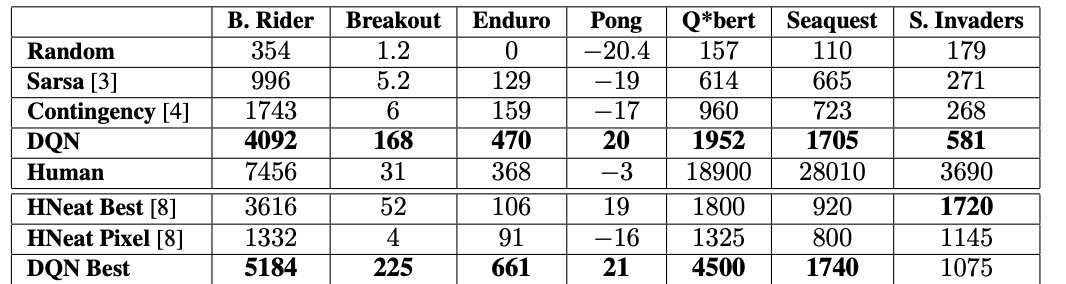

(Minh et al., 2013)

**Hyperparameter Selection**

In [ ]:
# Hyperparameters
clone_time = 10000      # As per original DeepMind paper (Minh et al., 2013) and OpenAI Baselines (OpenAI, 2017)
greedy_time = 1000000   # As per original DeepMind paper (Minh et al., 2013)
experience_time = 50000 # As per original DeepMind paper (Minh et al., 2013)
memory_depth = 1000000  # As per original DeepMind paper (Minh et al., 2013)
batch_size = 32         # As per OpenAI Baselines (OpenAI, 2017) and original DeepMind paper (Minh et al., 2013) and Rainbow DQN (Hessel et al., 2017)
lr = 2.5e-4             # As per Rainbow DQN (Hessel et al., 2017)
gamma = 0.99            # As per original DeepMind paper (Minh et al., 2013) and Rainbow DQN (Hessel et al., 2017)
starting_epsilon = 1
ending_epsilon = 0.1

**Prioritised Experience Replay**



# **References**

Mnih, Volodymyr, et al. "Playing Atari with Deep Reinforcement Learning." ArXiv, 2013,  https://arxiv.org/abs/1312.5602.


Schaul, Tom, et al. "Prioritized Experience Replay." ArXiv, 2015,  https://arxiv.org/abs/1511.05952.


Hessel, Matteo, et al. "Rainbow: Combining Improvements in Deep Reinforcement Learning." ArXiv, 2017,  https://arxiv.org/abs/1710.02298.


OpenAI Baselines: https://github.com/openai/baselines/blob/master/baselines/deepq/deepq.py

GitHub Repository for DQN based on Original DeepMind Paper: https://github.com/davidreiman/pytorch-atari-dqn/blob/master/dqn.ipynb